<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [2]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
)

In [5]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [7]:
BATCH_SIZE = 128  # tamaño del batch

# Carga de datos

## Carga de datos con transforms para LeNet


In [9]:
DATA_DIR = Path("data")

# transforms = T.Compose(
#     [
#         T.ToTensor(),              # convierte a tensor y normaliza a [0,1]
#         T.Resize((32, 32)),        # redimensiona
#     ]
# )
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
transforms = T.Compose(
    [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((32,32)),
        T.Grayscale(num_output_channels=1),
        # T.RandomResizedCrop(224, scale=(0.7, 1.0)),
        # T.RandomHorizontalFlip(p=0.5),
        # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        # T.ToTensor(),
        # T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

imagenette_train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=True, transform=transforms
)
imagenette_test_dataset = datasets.Imagenette(
    DATA_DIR, split="val", download=False, transform=transforms
)

## Carga de datos con transforms para otra red

# Exploracion de datos

In [11]:
imagenette_train_dataset[1][0].size()

torch.Size([1, 32, 32])

In [12]:
name_classes = imagenette_train_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [ ]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images
    print(f"{cls}: {n_images} imágenes")

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")


n03417042: 961 imágenes
n02979186: 993 imágenes
n03394916: 956 imágenes
n03028079: 941 imágenes
n03445777: 951 imágenes
n03000684: 858 imágenes
n03425413: 931 imágenes
n01440764: 963 imágenes
n02102040: 955 imágenes
n03888257: 960 imágenes

Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


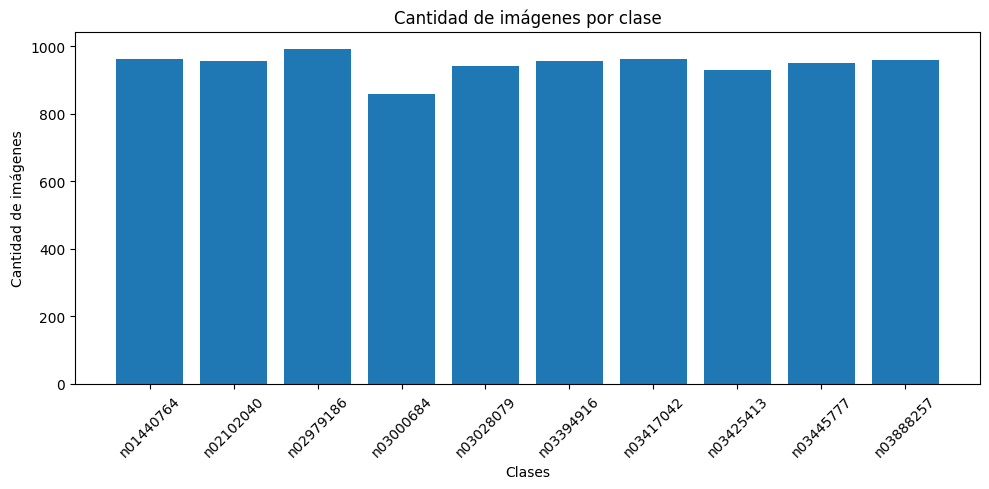

In [ ]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

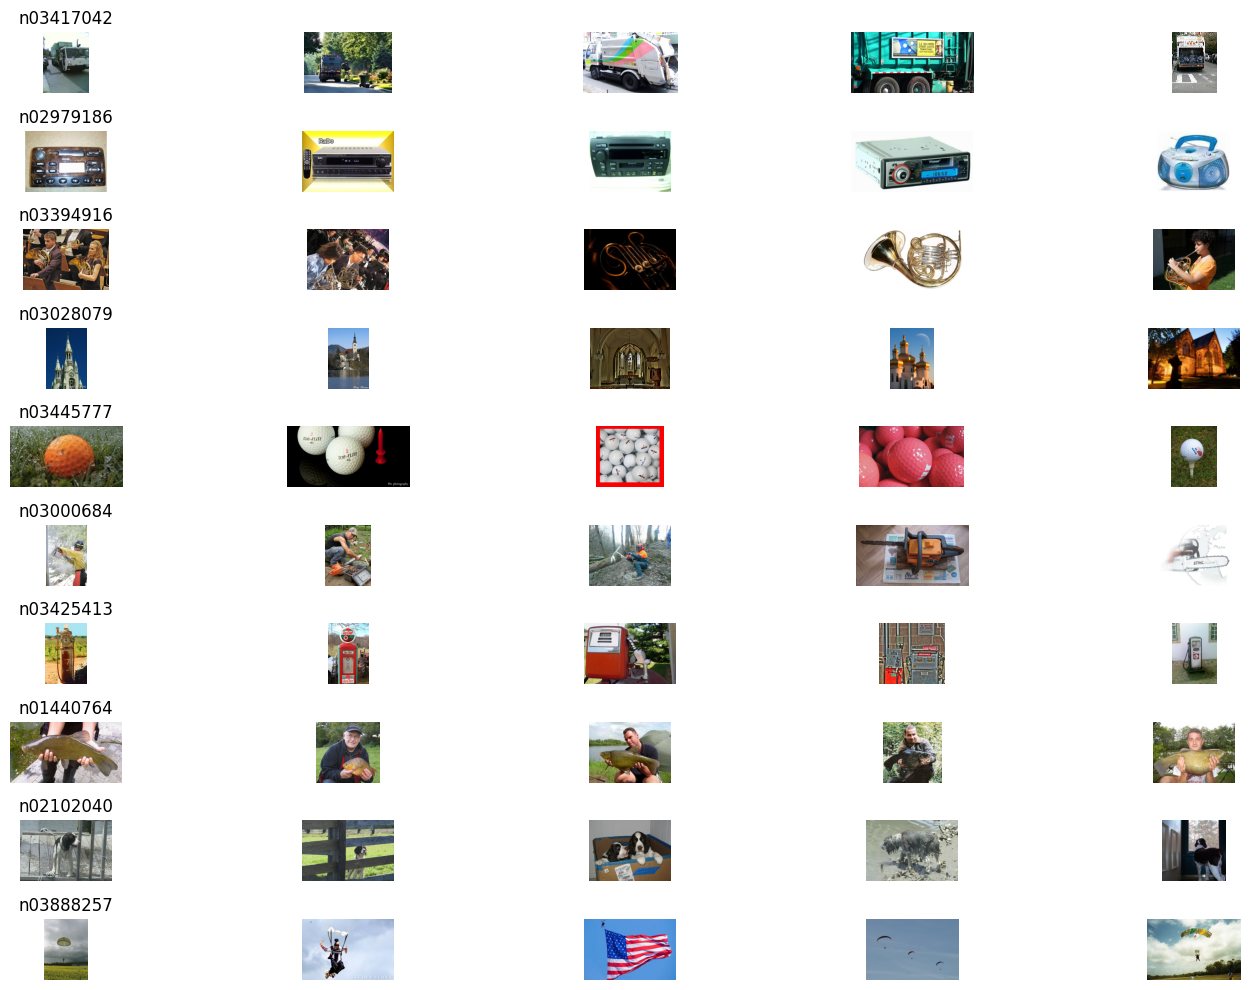

In [ ]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [ ]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"Tamaño de las imágenes: {sizes}")
print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")


Tamaño de las imágenes: [(1600, 1200), (500, 415), (500, 375), (350, 263), (640, 378), (375, 500), (500, 375), (500, 375), (500, 375), (500, 375), (500, 375), (500, 375), (500, 375), (500, 396), (500, 323), (500, 375), (500, 375), (360, 239), (500, 380), (144, 112), (384, 500), (1500, 1108), (500, 375), (456, 342), (800, 601), (375, 500), (500, 375), (500, 281), (500, 380), (500, 375), (500, 305), (375, 500), (500, 375), (500, 375), (2560, 1920), (500, 375), (251, 170), (480, 640), (500, 375), (500, 375), (1200, 1600), (500, 333), (500, 375), (500, 375), (225, 137), (1600, 1200), (651, 488), (1600, 1200), (500, 375), (640, 480), (500, 375), (250, 250), (500, 255), (712, 534), (160, 160), (300, 400), (1100, 816), (500, 495), (177, 150), (500, 334), (432, 324), (1115, 707), (500, 375), (177, 150), (480, 640), (500, 375), (500, 375), (500, 500), (500, 375), (500, 333), (334, 500), (500, 375), (500, 500), (375, 500), (375, 500), (146, 206), (149, 90), (553, 369), (576, 432), (500, 395), (4

## Buscar duplicados

In [ ]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


# Data Augmentation

!!!!!!!!!!!! Solo para test

## LeNet

## Otra red

# Preprocessing

Test y validation

In [ ]:
# resize de todas a un mismo tamaño ; elegir dependiendo del modelo que usemos. Por ej, si usaramos LeNet resize a 28x28 o 32x32
#

## LeNet

## Otra red

# LeNet

## Arquitectura del modelo

In [ ]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        imagenette_test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        x = self.flatten(x)
        x = self.tanh(self.linear(x))
        x = self.output(x)
        return x


summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 120, 1, 1]          48,120
├─Tanh: 1-8                              [128, 120, 1, 1]          --
├─Flatten: 1-9                           [128, 120]                --
├─Linear: 1-10                           [128, 84]                 10,164
├─Tanh: 1-11                             [128, 84]                 --
├─Linear: 1-12                           [128, 10]                 850
To

## Entrenamiento


In [ ]:
LR = 0.001
EPOCHS = 10

letnet_model = LeNet(1,10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

_, _ = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    True,
    5,
    EPOCHS
)

Epoch: 001 | Train Loss: 2.18937 | Val Loss: 2.09380
Epoch: 002 | Train Loss: 2.08788 | Val Loss: 2.05907
Epoch: 003 | Train Loss: 2.06636 | Val Loss: 2.03854
Epoch: 004 | Train Loss: 2.05190 | Val Loss: 2.03145
Epoch: 005 | Train Loss: 2.03358 | Val Loss: 2.03284
Epoch: 006 | Train Loss: 2.02494 | Val Loss: 2.01256
Epoch: 007 | Train Loss: 2.00274 | Val Loss: 1.99515
Epoch: 008 | Train Loss: 1.98090 | Val Loss: 1.97187
Epoch: 009 | Train Loss: 1.95944 | Val Loss: 1.96404
Epoch: 010 | Train Loss: 1.93653 | Val Loss: 1.94103


## Weight & Biases

## Conclusion de los datos

# Otra red

# Comparacion ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.